In [1]:
pip install pandas mlxtend matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


📦 Top Product Bundles (Association Rules):
            antecedents               consequents   support  confidence  \
4       Vareebadd Phone      USB-C Charging Cable  0.002062    0.178208   
2                iPhone  Lightning Charging Cable  0.005666    0.147807   
0  USB-C Charging Cable              Google Phone  0.005587    0.045619   

       lift  
4  1.454996  
2  1.220804  
0  1.474120  


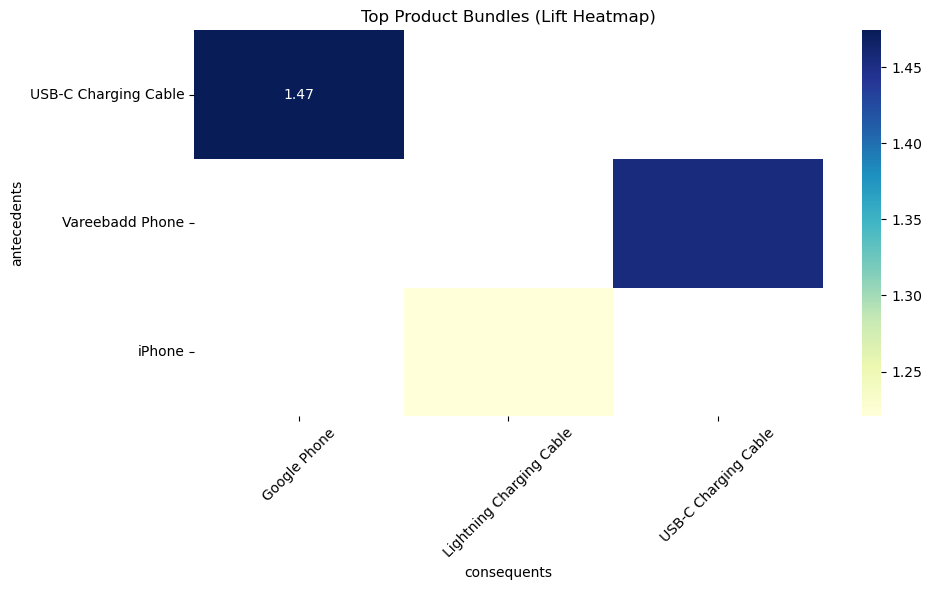

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Load data
df = pd.read_csv("data.csv")
df.dropna(inplace=True)

# Parse datetime safely with known format (MM/DD/YY HH:MM)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')
df.dropna(subset=['Order Date'], inplace=True)

# Filter orders that are part of bundles
df = df[df['Order ID'].duplicated(keep=False)]

# Combine products per order
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df = df[['Order ID', 'Grouped']].drop_duplicates()

# One-hot encoding
basket = df['Grouped'].str.get_dummies(sep=',')

# Generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.002, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.8)

# Convert frozensets to strings for display
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Remove duplicate rules like (A->B) & (B->A)
rules['pair'] = rules.apply(lambda x: tuple(sorted([x['antecedents'], x['consequents']])), axis=1)
rules = rules.drop_duplicates(subset='pair').drop(columns='pair')

# Top 10 rules by confidence
top_rules = rules.sort_values(by='confidence', ascending=False).head(20)

# Print
print("📦 Top Product Bundles (Association Rules):")
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Heatmap
plt.figure(figsize=(10, 6))
heatmap_data = top_rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Top Product Bundles (Lift Heatmap)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


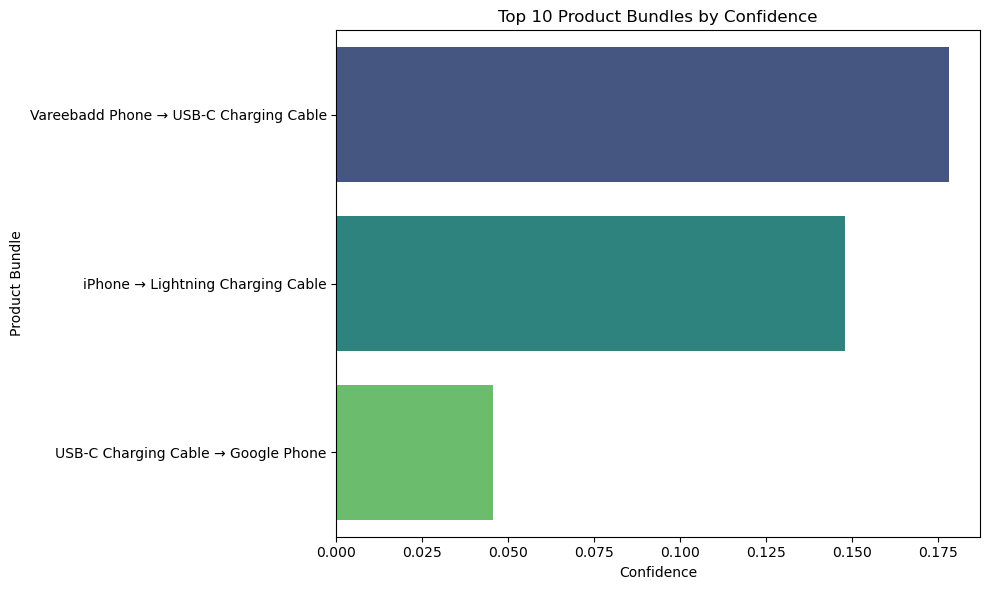

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ✅ Create 'Pair' column
top_rules['Pair'] = top_rules['antecedents'] + " → " + top_rules['consequents']

# 📊 Barplot of top product bundles by confidence
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='Pair', data=top_rules, palette='viridis')
plt.title("Top 10 Product Bundles by Confidence")
plt.xlabel("Confidence")
plt.ylabel("Product Bundle")
plt.tight_layout()
plt.show()


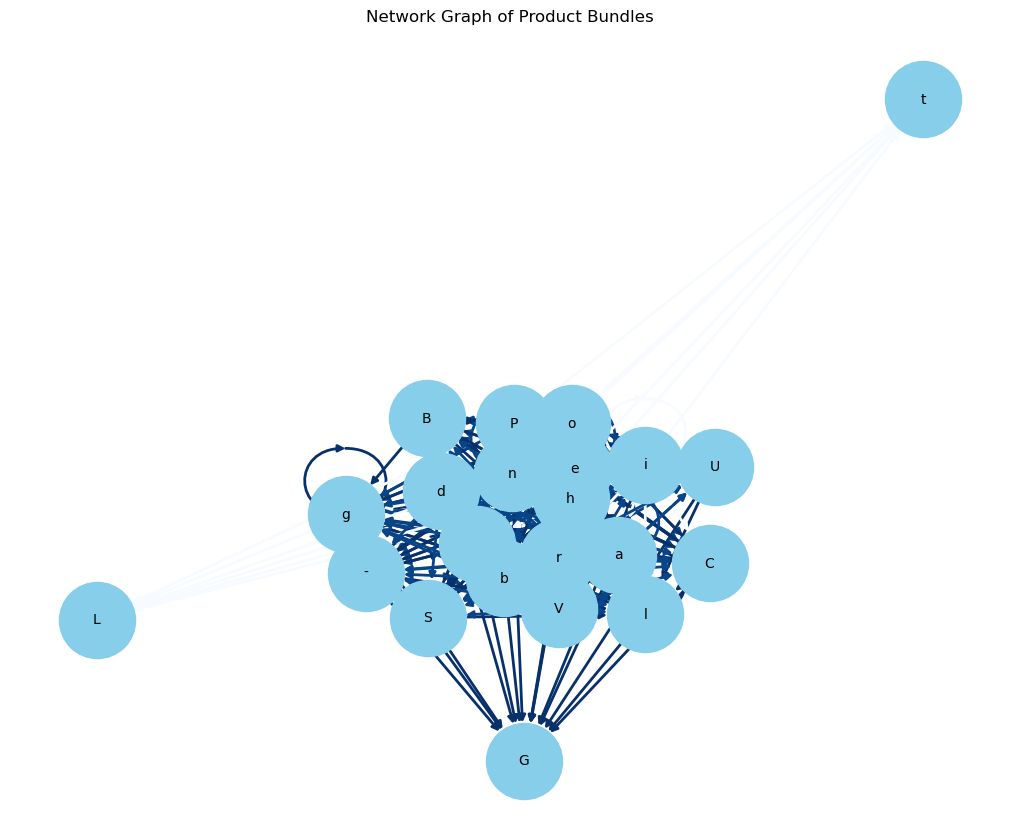

In [41]:
import networkx as nx

# Filter top rules for visualization
top_n_rules = rules.head(10)

# Create a directed graph
G = nx.DiGraph()

for _, row in top_n_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=1)
edges = G.edges(data=True)
weights = [d['weight'] for _, _, d in edges]
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
plt.title("Network Graph of Product Bundles")
plt.show()


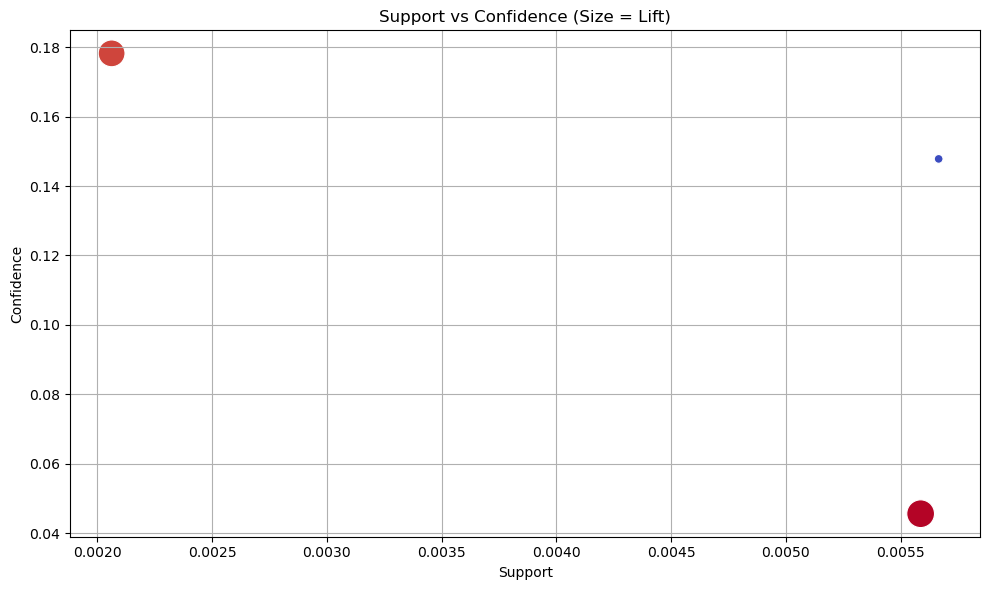

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='coolwarm', legend=False, sizes=(40, 400))
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (Size = Lift)')
plt.grid(True)
plt.tight_layout()
plt.show()

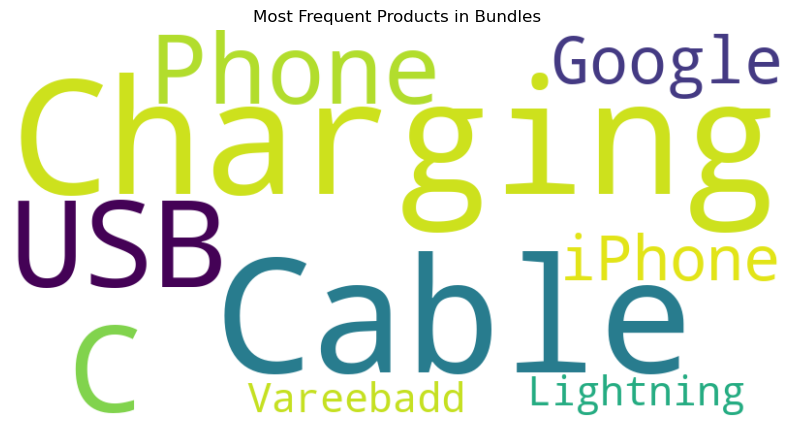

In [45]:
from wordcloud import WordCloud

# Combine antecedents and consequents
all_products = rules['antecedents'].astype(str) + ',' + rules['consequents'].astype(str)
text = ','.join(all_products).replace('frozenset(', '').replace(')', '').replace('{', '').replace('}', '')

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Products in Bundles")
plt.show()